In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


| Источник              | Полезные признаки                                            |
| --------------------- | ------------------------------------------------------------ |
| `train.csv`           | `date`, `store_nbr`, `item_nbr`, `unit_sales`, `onpromotion` |
| `stores.csv`          | `city`, `state`, `type`, `cluster` (по `store_nbr`)          |
| `transactions.csv`    | `transactions` (по `date` и `store_nbr`)                     |
| `oil.csv`             | `dcoilwtico` — цена нефти по дате                            |
| `holidays_events.csv` | праздники и события — по `date`                              |


In [2]:
train = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])


In [3]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [5]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
oil.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [7]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [8]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


# 2. Merge with stores

In [9]:
train = train.merge(stores, on='store_nbr', how='left')
test = test.merge(stores, on='store_nbr', how='left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


# 3. Merge with transactions

In [10]:
train = train.merge(transactions, on=['date', 'store_nbr'], how='left')
test = test.merge(transactions, on=['date', 'store_nbr'], how='left')
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


# 4. Merge with oil (interpolate missing values)

In [11]:
oil = oil.set_index('date').resample('D').mean().interpolate()
oil.reset_index(inplace=True)
train = train.merge(oil, on='date', how='left')
test = test.merge(oil, on='date', how='left')
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN


# 5. Merge holidays: binary features

In [12]:
def process_holidays(df):
    df = df.copy()
    df['is_holiday'] = 1
    df = df[['date', 'is_holiday', 'type', 'locale']]
    df = df.drop_duplicates('date')
    df = df.pivot_table(index='date', 
                        values='is_holiday', 
                        aggfunc='max').reset_index()
    return df

holiday_features = process_holidays(holidays)
train = train.merge(holiday_features, on='date', how='left')
test = test.merge(holiday_features, on='date', how='left')


train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0


train['is_holiday'] = train['is_holiday'].fillna(0)
test['is_holiday'] = test['is_holiday'].fillna(0)

In [13]:
print(train['is_holiday'].isna().sum())

train['is_holiday'] = train['is_holiday'].fillna(0)
print(train['is_holiday'].isna().sum())

2551824
0


In [14]:
print(test['is_holiday'].isna().sum())

test['is_holiday'] = test['is_holiday'].fillna(0)
print(test['is_holiday'].isna().sum())

26730
0


# 6. Date features

In [15]:
for df in [train, test]:
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [16]:
train.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,dcoilwtico,is_holiday,day,month,year,day_of_week,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0,1,1,2013,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0,1,1,2013,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0,1,1,2013,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0,1,1,2013,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,1.0,1,1,2013,1,0


In [17]:
test.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,date,store_nbr,family,onpromotion,city,state,type,cluster,transactions,dcoilwtico,is_holiday,day,month,year,day_of_week,is_weekend
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,46.8,0.0,16,8,2017,2,0
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,46.8,0.0,16,8,2017,2,0
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,46.8,0.0,16,8,2017,2,0
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,46.8,0.0,16,8,2017,2,0
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,46.8,0.0,16,8,2017,2,0


Что с ними делать:
Категориальные признаки — нужно закодировать в числа, чтобы модель поняла:

family
city
state
type
cluster

Числовые и бинарные признаки — можно использовать напрямую:

store_nbr, onpromotion, transactions, dcoilwtico, is_holiday, day, month, year, day_of_week, is_weekend

Дата — если хочешь, можно оставить или убрать, так как её признаки уже распарсены (day, month, year и т.д.).



# 8. Encode categoricals

In [18]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['family', 'city', 'state', 'type', 'cluster']
# --- 1. Закодируем категориальные признаки ---

for col in cat_cols:
    le = LabelEncoder()
    train[col + '_encoded'] = le.fit_transform(train[col])
    test[col + '_encoded'] = le.transform(test[col])

Как работает LabelEncoder?
Допустим, у тебя есть колонка city:
city
Москва
Санкт-Петербург
Москва
Новосибирск

LabelEncoder преобразует её так:

city	city_encoded
Москва	0
Санкт-Петербург	1
Москва	0
Новосибирск	2

То есть каждое уникальное слово получает своё число.

Пример кода:
from sklearn.preprocessing import LabelEncoder


> le = LabelEncoder()
> cities = ['Москва', 'Санкт-Петербург', 'Москва', 'Новосибирск']
> encoded = le.fit_transform(cities)print(encoded)  # Выведет: [0 1 0 2]


Важные моменты:
Для обучения модели нужно сначала обучить (fit) энкодер на тренировочных данных, а потом преобразовывать (transform) и тренировочные, и тестовые данные.

Числа — это просто метки, они не означают порядок или величину.

In [19]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,day,month,year,day_of_week,is_weekend,family_encoded,city_encoded,state_encoded,type_encoded,cluster_encoded
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1,1,2013,1,0,0,18,12,3,12
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,1,1,2013,1,0,1,18,12,3,12
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,1,1,2013,1,0,2,18,12,3,12
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,1,1,2013,1,0,3,18,12,3,12
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,1,1,2013,1,0,4,18,12,3,12


In [20]:
train['transactions'] = train['transactions'].fillna(train['transactions'].median())
test['transactions'] = test['transactions'].fillna(train['transactions'].median())

In [21]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(train['dcoilwtico'].mean())
test['dcoilwtico'] = test['dcoilwtico'].fillna(test['dcoilwtico'].mean())

In [22]:
print(train.isna().sum())
print(test.isna().sum())

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type               0
cluster            0
transactions       0
dcoilwtico         0
is_holiday         0
day                0
month              0
year               0
day_of_week        0
is_weekend         0
family_encoded     0
city_encoded       0
state_encoded      0
type_encoded       0
cluster_encoded    0
dtype: int64
id                 0
date               0
store_nbr          0
family             0
onpromotion        0
city               0
state              0
type               0
cluster            0
transactions       0
dcoilwtico         0
is_holiday         0
day                0
month              0
year               0
day_of_week        0
is_weekend         0
family_encoded     0
city_encoded       0
state_encoded      0
type_encoded       0
cluster_encoded    0
dtype: int64


In [23]:
# --- 2. Логарифмируем и ограничиваем целевой признак ---
train['sales'] = np.log1p(train['sales'])
train['sales'] = train['sales'].clip(lower=0, upper=10)

# 9. Features

In [24]:
# --- 3. Формируем признаки и целевой вектор ---
features = ['store_nbr', 'family_encoded', 'onpromotion', 'transactions', 'dcoilwtico',
            'city_encoded', 'state_encoded', 'type_encoded', 'cluster',
            'day', 'month', 'year', 'day_of_week', 'is_weekend', 'is_holiday']

X = train[features]
y = train['sales']
X_test = test[features]

In [25]:
X.head()

,store_nbr,family_encoded,onpromotion,transactions,dcoilwtico,city_encoded,state_encoded,type_encoded,cluster,day,month,year,day_of_week,is_weekend,is_holiday
0,1,0,0,1393.0,67.878342,18,12,3,13,1,1,2013,1,0,1.0
1,1,1,0,1393.0,67.878342,18,12,3,13,1,1,2013,1,0,1.0
2,1,2,0,1393.0,67.878342,18,12,3,13,1,1,2013,1,0,1.0
3,1,3,0,1393.0,67.878342,18,12,3,13,1,1,2013,1,0,1.0
4,1,4,0,1393.0,67.878342,18,12,3,13,1,1,2013,1,0,1.0


In [26]:

# --- 4. Масштабируем числовые признаки ---
from sklearn.preprocessing import RobustScaler

num_cols = ['transactions', 'dcoilwtico', 'day', 'month', 'year', 'day_of_week']
scaler = RobustScaler()

X.loc[:, num_cols] = scaler.fit_transform(X[num_cols])
X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])

/tmp/ipykernel_35/1413232593.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.         -1.         -1.         ... -0.06666667 -0.06666667
 -0.06666667]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[:, num_cols] = scaler.fit_transform(X[num_cols])
/tmp/ipykernel_35/1413232593.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.83333333 -0.83333333 -0.83333333 ...  0.33333333  0.33333333
  0.33333333]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[:, num_cols] = scaler.fit_transform(X[num_cols])
/tmp/ipykernel_35/1413232593.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1. -1. -1. ...  1.  1.  1.]' has dtype incompatible with int32, please explicitly cast to a

🔍 Что делает RobustScaler?
Он нормализует данные не по среднему и стандартному отклонению, а по медиане и интерквартильному размаху (IQR):


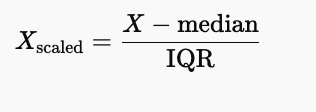
​
 
Где:

median — медиана признака,

IQR (interquartile range) = 75-й перцентиль − 25-й перцентиль.

🔧 Почему это полезно?
Если в данных есть выбросы (например, продажи в Черную пятницу или аномальные цены на нефть), то:

StandardScaler и MinMaxScaler могут сильно "исказить" масштаб;

RobustScaler проигнорирует эти экстремальные значения и даст более стабильное обучение модели.

In [27]:
X

,store_nbr,family_encoded,onpromotion,transactions,dcoilwtico,city_encoded,state_encoded,type_encoded,cluster,day,month,year,day_of_week,is_weekend,is_holiday
0,1,0,0,0.000000,0.295035,18,12,3,13,-1.000000,-0.833333,-1.0,-0.5,0,1.0
1,1,1,0,0.000000,0.295035,18,12,3,13,-1.000000,-0.833333,-1.0,-0.5,0,1.0
2,1,2,0,0.000000,0.295035,18,12,3,13,-1.000000,-0.833333,-1.0,-0.5,0,1.0
3,1,3,0,0.000000,0.295035,18,12,3,13,-1.000000,-0.833333,-1.0,-0.5,0,1.0
4,1,4,0,0.000000,0.295035,18,12,3,13,-1.000000,-0.833333,-1.0,-0.5,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,28,0,0.853065,-0.116010,18,12,1,6,-0.066667,0.333333,1.0,-0.5,0,1.0
3000884,9,29,1,0.853065,-0.116010,18,12,1,6,-0.066667,0.333333,1.0,-0.5,0,1.0
3000885,9,30,148,0.853065,-0.116010,18,12,1,6,-0.066667,0.333333,1.0,-0.5,0,1.0
3000886,9,31,8,0.853065,-0.116010,18,12,1,6,-0.066667,0.333333,1.0,-0.5,0,1.0


# 10. Train/Val split

In [28]:
from sklearn.model_selection import train_test_split
# --- 5. Делим на тренировочную и валидационную выборки ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# 11. Model training with early stopping

✅ What does early stopping do in LightGBM?
In training, the model gets better and better on training data. But after a point, it might start overfitting — doing well on training data but worse on validation (real-life-like) data.

Early stopping watches performance on the validation set, and:

If the model doesn't improve after N rounds (say, 50), it stops training early

Saves time ⏱️

Helps avoid overfitting

🔍 Что делает этот код?
Он обучает модель LightGBM, а именно LGBMRegressor, и использует:

1. X_train, y_train
Это — обучающие данные и целевая переменная (например, sales).

2. eval_set=[(X_val, y_val)]
Это — валидационная выборка, на которой модель оценивает качество на каждом этапе обучения.

3. eval_metric='rmse'
Модель будет использовать RMSE (корень из среднеквадратичной ошибки) как метрику — чем ниже, тем лучше.

4. callbacks:
📌 lgb.early_stopping(stopping_rounds=500)
Если модель не улучшает RMSE на валидации 500 итераций подряд — обучение остановится.

Это помогает избежать переобучения и сэкономить время.

📌 lgb.log_evaluation(period=100)
Пишет лог (выводит RMSE) каждые 100 итераций, чтобы ты видел прогресс.

In [ ]:
import lightgbm as lgb
# --- 6. Создаем и обучаем модель LightGBM с ранней остановкой ---
model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.156362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 2400710, number of used features: 15
[LightGBM] [Info] Start training from score 2.926514
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.850732	valid_0's l2: 0.723744
[200]	valid_0's rmse: 0.68131	valid_0's l2: 0.464183


🧠 Причина:
В новых версиях библиотеки LightGBM early_stopping_rounds больше не используется напрямую в fit() у LGBMRegressor. Вместо этого нужно использовать callbacks.

Что делает этот код:
early_stopping(stopping_rounds=50) — останавливает обучение, если 50 раундов нет улучшений

log_evaluation(period=100) — показывает лог каждые 100 итераций (можно поменять)

📊 What is “RMSE per iteration”? ✅ RMSE stands for: Root Mean Squared Error — it measures how far off your model's predictions are, on average.

Lower RMSE = better model

It's used often in regression problems (like predicting sales)

📈 "Per iteration" means: LightGBM trains the model in many small steps (called iterations, also known as boosting rounds).

On each iteration, it tries to make the model better. We track how the RMSE changes after each step:

At the beginning: the model is bad → RMSE is high 😬

As training goes on: RMSE goes down 😎

If RMSE starts going up → model is overfitting

🧠 Why plot it? Because the plot helps you: See how well the model is learning Choose the best number of iterations Spot overfitting (when error on validation starts rising)

In [ ]:
import matplotlib.pyplot as plt
# --- 7. Предсказания и визуализация результатов на валидации ---
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration_)
y_val_pred = np.expm1(np.clip(y_val_pred, a_min=None, a_max=15))

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(np.expm1(y_val), bins=100, alpha=0.5, label='Real sales')
plt.hist(y_val_pred, bins=100, alpha=0.5, label='Predicted sales')
plt.legend()
plt.title('Real vs Predicted Sales (Validation)')
plt.show()

In [ ]:
# --- 8. Финальное предсказание на тестовых данных ---
y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
y_pred = np.expm1(np.clip(y_pred, a_min=None, a_max=15))

In [ ]:
# --- 9. Создаем submission ---
submission = pd.DataFrame({
    'id': test['id'],
    'unit_sales': y_pred
})
submission.to_csv('submission.csv', index=False)